In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Subset, Dataset
import torchvision.transforms as transforms

import torchvision

from numpy.random import seed
import torch
import numpy as np

from torchinfo import summary
import matplotlib.pyplot as plt

In [ ]:
# Fix random number so that your traing process can be replicated

random_seed = 124
seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [ ]:
import pandas as pd
from sklearn.utils import shuffle


In [ ]:
data = pd.read_csv("Emotion_final.csv")
data.head()
len(data)

data = shuffle(data)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


21459

In [ ]:
# Map text label to numbers

label_map = {'fear':0, 'happy':1, 'anger':2, 'surprise':3, 'sadness':4, 'love':5}
data["label"] = data.Emotion.apply(lambda x: label_map[x])
data.head()
data.label.value_counts()

,Text,Emotion,label
15620,lost my girlfriend,sadness,4
432,i were feeling energetic so we decided we were...,happy,1
3963,i should just leave him be so he could go on h...,sadness,4
17564,i feel drained and i am physically sore from t...,sadness,4
3018,i nodded proud of my decision to procure a pum...,happy,1


1    7029
4    6265
2    2993
0    2652
5    1641
3     879
Name: label, dtype: int64

In [ ]:
# Split dataset into training, evaluation, and test

train_data = data.iloc[0: 15000]
eval_data = data.iloc[15000: 18000]
test_data = data.iloc[18000: ]

[]

15997


1     8393
2     2323
3     1115
4      722
5      439
6      301
7      260
8      203
9      148
11     131
dtype: int64

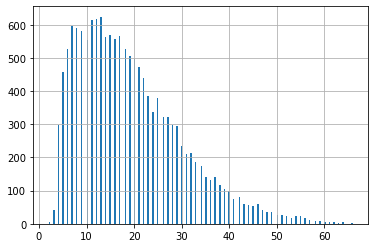

In [ ]:
# A few exploration steps. This plots shows the sentence length can be set to 50 
# and vocab size can be set around 8000 
from tensorflow import keras

# check document length
(train_data.apply(lambda row: len(row["Text"].split()), axis = 1)).hist(bins = 200).plot()
#(train_data.apply(lambda row: len(row["title"].split()), axis = 1)).hist(bins = 200).plot()

# check word frequencies
tokenizer = keras.preprocessing.text.Tokenizer()
#tokenizer.fit_on_texts(train_data["title"] +" "+ train_data["text"])
tokenizer.fit_on_texts(train_data["Text"])

print(len(tokenizer.word_counts))
word_counts = pd.Series(list(tokenizer.word_counts.values()))
word_counts.value_counts().sort_values(ascending = False)[0:10]

In [ ]:
class News_dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.Tensor(x).long()
        self.y = torch.Tensor(y).long()
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.x.size()[0]


In [ ]:
def preprocess(train_data, eval_data, test_data, vocab_size = 10000, max_sent = 50):
    
    tokenizer = keras.preprocessing.text.Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts(train_data["Text"])

    train_seq = tokenizer.texts_to_sequences(train_data["Text"])
    train_seq = keras.preprocessing.sequence.pad_sequences(train_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    eval_seq = tokenizer.texts_to_sequences(eval_data["Text"])
    eval_seq = keras.preprocessing.sequence.pad_sequences(eval_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    
    test_seq = tokenizer.texts_to_sequences(test_data["Text"])
    test_seq = keras.preprocessing.sequence.pad_sequences(test_seq,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_sent)

    # dataset
    train_dataset = News_dataset(train_seq, train_data["label"].values)
    eval_dataset = News_dataset(eval_seq, eval_data["label"].values)
    test_dataset = News_dataset(test_seq, test_data["label"].values)
    
    return train_dataset, eval_dataset, test_dataset, tokenizer

In [ ]:
vocab_size = 10000
max_sent = 50

train_dataset, eval_dataset, test_dataset, tokenizer = preprocess(train_data, eval_data, test_data, \
                                                       vocab_size, max_sent )

In [ ]:
#tokenizer.word_index

### Load pretrained word vectors 

In [ ]:
#!pip install torchtext

In [ ]:
import torchtext
emb_dim = 100

vector = torchtext.vocab.GloVe(name='6B', dim=100)

In [ ]:

missing_words = []  # check if any word without a vector

# initialize embedding matrix
emb_weight = np.zeros((vocab_size, emb_dim))

# loop through all words
for word, idx in tokenizer.word_index.items():

  # align with word index in sentences, since the first 3 indexes are reserved
  if idx < vocab_size :  
    try:
      emb = vector[word]
      emb_weight[idx] = emb    

    # not every word has a vector
    except:
      missing_words.append(word)
    
print(missing_words)

[]


In [ ]:
# Check alignment. These two must be the same

idx = tokenizer.word_index['city']
print(emb_weight[idx])

print(vector['city'])

[ 2.65720010e-01  3.48570012e-02  4.90550011e-01 -6.74019992e-01
  3.28830004e-01  9.99170005e-01 -1.03050005e+00  6.94920003e-01
  3.43580008e-01  8.57919991e-01 -4.38039988e-01 -8.18350017e-01
  2.68680006e-01 -2.50829995e-01  1.54660001e-01 -8.32239985e-01
  1.17270005e+00 -1.86039999e-01 -5.29290020e-01  1.76530004e-01
  8.07470024e-01 -1.40310004e-01 -2.40310002e-02 -6.11579977e-03
 -6.02169991e-01 -6.71710014e-01  2.06980005e-01 -5.09480000e-01
 -3.29899997e-01 -3.94540012e-01 -4.59270000e-01 -2.89310008e-01
  7.88110018e-01  4.44830000e-01 -4.86970007e-01 -2.36300007e-01
 -1.50809996e-02  1.66060001e-01 -3.41719985e-02  8.40490013e-02
 -8.60819966e-02 -9.01499987e-01 -2.01989993e-01 -5.60479999e-01
  8.64350021e-01  3.27419996e-01  3.81839991e-01 -2.43340001e-01
  5.97230017e-01  1.74640000e-01 -4.47560012e-01 -3.34769994e-01
  3.24229985e-01  1.02310002e+00 -5.49459994e-01 -2.85200000e+00
 -5.76399982e-01 -3.57600003e-01  1.41040003e+00  3.07570010e-01
 -3.88520002e-01  7.43019

In [ ]:
emb_matrix = torch.Tensor(emb_weight)
print(emb_matrix.shape)

torch.Size([10000, 100])


#### Model Definition

In [ ]:
class rnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, hidden_units , \
                 num_layers = 1,  bidirectional = False, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(rnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.bidirectional = bidirectional
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.rnn = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units,\
                           num_layers = self.num_layers, \
                           bidirectional = self.bidirectional,\
                           batch_first = True,\
                           #dropout = dropout_rate
                          )
        
        feature_size = self.hidden_units * 2
        if self.bidirectional:
            feature_size = self.hidden_units * 4
            
        self.fc = nn.Linear(feature_size, self.num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        #print(x.size())
        #x = torch.swapaxes(x, 1, 2) # Batch x emb_dim x max_sent 

        x, _ = self.rnn(x)  # batch, seq_len, self.hidden_units*(2 if self.bidirectional else 0)
        #print(x.size())
        x = self.dropout(x)
        x = torch.cat([x[:,-1,:],x[:,0,:]], dim = -1)
        
        logit = self.fc(x)  

        return logit

In [ ]:
from torchsummary import summary
model = rnn_text(10000, 100, 6, 100 , \
                 num_layers = 1,  bidirectional = True, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5)
                 
                
#summary(model, (16,50))
print(model)

rnn_text(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


#### Training function

In [ ]:
from sklearn.metrics import classification_report

def train_model(model, train_dataset, eval_dataset,  device, 
                optimizer, epochs=30, batch_size=64):
    
    # construct dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    #test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # move model to device
    model = model.to(device)

    # history
    history = {'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': [],
               'test_acc': 0}
    
    patience = 10
    max_acc = -np.Inf
    cnt = 0
    
    # setup loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    # training loop
    print('Training Start')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for x, y in train_loader:
            
            # move data to device
            x = x.to(device)
            y = y.to(device)
            
            # forward
            outputs = model(x)  # (num_batch, 45) 
            _, pred = torch.max(outputs, dim = -1)
            cur_train_loss = criterion(outputs, y)
            cur_train_acc = (pred == y).float().mean().item()
            
            # backward
            cur_train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # loss and acc
            train_loss += cur_train_loss
            train_acc += cur_train_acc

        # test start
        model.eval()
        with torch.no_grad():
            for x, y in eval_loader:
                # move
                x = x.to(device)
                y = y.to(device)
                # predict
                
                outputs = model(x)  # (num_batch, 45) 
                _, pred = torch.max(outputs, dim = -1)
                cur_test_loss = criterion(outputs, y)
                cur_test_acc = (pred == y).float().mean().item() 
                # loss and acc
                test_loss += cur_test_loss
                test_acc += cur_test_acc

        # epoch output
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(eval_loader)).item()
        val_acc = test_acc/len(eval_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train loss:{train_loss:.4f},\
        train_acc:{train_acc:.4f}, valid loss:{val_loss:.4f} valid acc:{val_acc:.4f}")
        
        if test_acc > max_acc:
            max_acc = test_acc
            cnt = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("model saved!")
        else:
            cnt += 1
            
            if cnt == patience:
                print("early stopping!")
                break
    
    # restore best model
    model.load_state_dict(torch.load("best_model.pth"))
    
    return model, history

In [ ]:
def test_model(model, test_dataset, batch_size = 64):    # get test performance
    
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    test_acc = 0
    ys = []
    preds = []
    
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            # move
            x = x.to(device)
            y = y.to(device)
            # predict
            outputs = model(x)
            _, pred = torch.max(outputs, dim = -1)
            
            ys.append(y.cpu().numpy())
            preds.append(pred.cpu().numpy())
    
    ys = np.concatenate(ys)
    preds = np.concatenate(preds)
    
    test_acc = (preds == ys).astype(int).mean()
    print(classification_report(ys, preds))
        
    print(f"Test acc: {test_acc:.4f}")
    
    return test_acc

In [ ]:
def get_plot(hist_list, labels, epochs):
    
    colors = ['red',"blue","green","orange"]
    
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    for i, hist in enumerate(hist_list):
        ax[0].plot(range(len(hist['val_loss'])), hist['val_loss'], '-', color = colors[i], label=labels[i])
        
    ax[0].set_title('Evaluation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    for i, hist in enumerate(hist_list):
        ax[1].plot(range(len(hist['val_acc'])), hist['val_acc'], '-', color = colors[i], label=labels[i])
        

    ax[1].set_title('Evaluation Acc.')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Acc.')
    ax[1].legend()
   
    plt.show()

#### Train model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
emb_dim = 100
hidden_units = emb_dim
num_layers = 1
bidirectional = True
num_classes = 6
vocab_size = 10000

In [ ]:
# Case C: Use word vectors and allow fine tuning

model_rnn = rnn_text(vocab_size = vocab_size , emb_dim = emb_dim, 
                       num_classes = num_classes, hidden_units = hidden_units , \
                       num_layers = num_layers,  bidirectional =  True, \
                       emb_weight =  emb_matrix, freeze = False, dropout_rate = 0.5)
                  
print(model_rnn)

optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.0005)

model_rnn, hist_rnn = train_model(model_rnn, train_dataset, eval_dataset, \
                           device, optimizer, epochs=100)



rnn_text(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training Start
Epoch:1 / 100, train loss:1.1766,        train_acc:0.5480, valid loss:0.7642 valid acc:0.7395
model saved!
Epoch:2 / 100, train loss:0.4544,        train_acc:0.8539, valid loss:0.4733 valid acc:0.8594
model saved!
Epoch:3 / 100, train loss:0.1872,        train_acc:0.9538, valid loss:0.3779 valid acc:0.8883
model saved!
Epoch:4 / 100, train loss:0.1097,        train_acc:0.9720, valid loss:0.3838 valid acc:0.8947
model saved!
Epoch:5 / 100, train loss:0.0797,        train_acc:0.9786, valid loss:0.4258 valid acc:0.8910
Epoch:6 / 100, train loss:0.0745,        train_acc:0.9795, valid loss:0.4664 valid acc:0.8835
Epoch:7 / 100, train loss:0.0555,        train_acc:0.9834, valid loss:0.4124 valid acc:0.8943
Epoch:8 / 100, train loss:0.0517,        train_acc:0.9846, val

In [ ]:
test_acc_rnn = test_model(model_rnn, test_dataset)

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       394
           1       0.94      0.90      0.92      1180
           2       0.86      0.91      0.89       479
           3       0.79      0.71      0.75       129
           4       0.92      0.95      0.94      1027
           5       0.77      0.82      0.79       250

    accuracy                           0.90      3459
   macro avg       0.86      0.86      0.86      3459
weighted avg       0.90      0.90      0.90      3459

Test acc: 0.8977


### RNN + CNN Model

#### Model Definition

In [ ]:
class rnn_cnn_text(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, emb_dim, num_classes, 
                 num_filters,  kernel_sizes,
                 hidden_units , num_layers = 1,  bidirectional = False, \
                 emb_weight = None, freeze = False, dropout_rate = 0.5):
      
        super(rnn_cnn_text, self).__init__()
        
        self.emb_dim = emb_dim
        
        self.num_filters = num_filters
        self.kernel_sizes = kernel_sizes
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.bidirectional = bidirectional
        self.num_classes = num_classes
       
        if emb_weight is None:      
            self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = 0)
        else:
            self.embedding = nn.Embedding.from_pretrained(emb_weight, freeze=freeze)
        
        self.rnn = nn.LSTM(input_size = self.emb_dim, hidden_size = self.hidden_units,\
                           num_layers = self.num_layers, \
                           bidirectional = self.bidirectional,\
                           batch_first = True,\
                           #dropout = dropout_rate
                          )
        
        feature_size = self.hidden_units 
        
        if self.bidirectional:
            feature_size = self.hidden_units * 2
        
        self.convs = nn.ModuleList([nn.Conv1d(feature_size, self.num_filters, f) for f in self.kernel_sizes])
        
            
        self.fc = nn.Linear(len(kernel_sizes)*self.num_filters, self.num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.embedding(x) # Batch x sent_len x emb_dim
        
        x, _ = self.rnn(x)  # batch, seq_len, features (self.hidden_units*(2 if self.bidirectional else 1))
        
        x = torch.swapaxes(x, 1, 2) # Batch x max_sent x features
        
        x = [F.relu(conv(x)) for conv in self.convs]  # output of three conv, batch x num_filter x L

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] # continue with 3 maxpooling

        x = torch.cat(x, 1)

        x = self.dropout(x)
        
        logit = self.fc(x)  

        return logit

In [ ]:
emb_dim = 100
hidden_units = emb_dim
num_layers = 1
bidirectional = True
num_classes = 6
vocab_size = 10000
num_filters = 30
kernel_sizes = [1,3,5]

#### Train Model

In [ ]:
model_rnn_cnn = rnn_cnn_text(vocab_size = vocab_size , emb_dim = emb_dim, 
                       num_filters = num_filters,  kernel_sizes = kernel_sizes,
                       num_classes = num_classes, hidden_units = hidden_units , \
                       num_layers = num_layers,  bidirectional =  True, \
                       emb_weight =  emb_matrix, freeze = False, dropout_rate = 0.5)
                  
print(model_rnn_cnn)

optimizer = torch.optim.Adam(model_rnn_cnn.parameters(), lr=0.0005)

model_rnn_cnn, hist_rnn_cnn = train_model(model_rnn_cnn, train_dataset, eval_dataset, \
                           device, optimizer, epochs=100)



rnn_cnn_text(
  (embedding): Embedding(10000, 100)
  (rnn): LSTM(100, 100, batch_first=True, bidirectional=True)
  (convs): ModuleList(
    (0): Conv1d(200, 30, kernel_size=(1,), stride=(1,))
    (1): Conv1d(200, 30, kernel_size=(3,), stride=(1,))
    (2): Conv1d(200, 30, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=90, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Training Start
Epoch:1 / 100, train loss:0.7014,        train_acc:0.7514, valid loss:0.2683 valid acc:0.9108
model saved!
Epoch:2 / 100, train loss:0.1019,        train_acc:0.9702, valid loss:0.2802 valid acc:0.9123
model saved!
Epoch:3 / 100, train loss:0.0632,        train_acc:0.9794, valid loss:0.3269 valid acc:0.9090
Epoch:4 / 100, train loss:0.0515,        train_acc:0.9834, valid loss:0.2856 valid acc:0.9119
Epoch:5 / 100, train loss:0.0423,        train_acc:0.9863, valid loss:0.3262 valid acc:0.9119
Epoch:6 / 100, train loss:0.0394,        train_acc:0.9872, valid loss:0.3555 v

In [ ]:
test_acc_rnn_cnn = test_model(model_rnn_cnn, test_dataset)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       394
           1       0.94      0.93      0.93      1180
           2       0.90      0.93      0.92       479
           3       0.85      0.74      0.79       129
           4       0.95      0.96      0.95      1027
           5       0.79      0.83      0.81       250

    accuracy                           0.92      3459
   macro avg       0.89      0.88      0.88      3459
weighted avg       0.92      0.92      0.92      3459

Test acc: 0.9167


Test acc: RNN: 0.898, RNN + CNN: 0.917


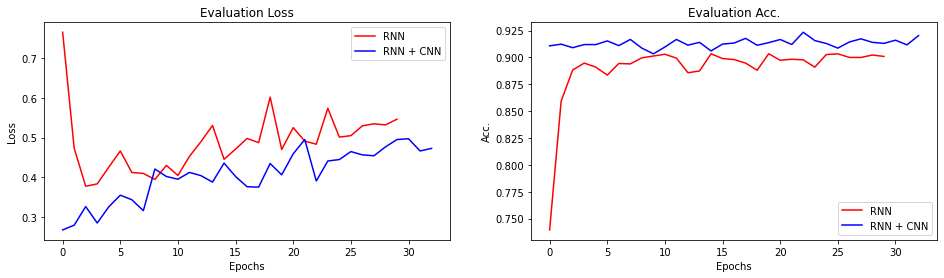

In [ ]:
print(f"Test acc: RNN: {test_acc_rnn:.3f}, RNN + CNN: {test_acc_rnn_cnn:.3f}")

get_plot([hist_rnn, hist_rnn_cnn], ["RNN",'RNN + CNN'], len(hist_rnn['val_loss']))